In [1]:
from brian2 import *
import numpy as np
# from matplotlib import pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib import animation
%matplotlib inline

Excitatory Neurons:
$$ \tau_m^+ \frac{\phi^P(\vec r, t+\Delta t)  - \phi^p(\vec r, t)}{\Delta t} + \phi^P(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + \Sigma_{\vec r'}w^-(\vec r - \vec r')s^-(\vec r', t - \tau_s^-) + a^+(\vec r)[1 + \alpha E^P \bullet V(t)] + \zeta^P(\vec r, t)  $$

Inhibitory Neurons:
$$ \tau_m^+ \frac{\phi^-(\vec r, t+\Delta t)  - \phi^-(\vec r, t)}{\Delta t} + \phi^-(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + a^-(t) + \zeta^-(\vec r, t)  $$

Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 - cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

$$ a^+(\vec r) = \begin{cases}
                -a_{min}^+ + (a^+_{max} - a^+_{min})^{\frac{1 + cos(\pi \rho /\rho_{a^+})}{2}}& \text{; } \rho < \rho a+\\
                a_{min}^+          & \text{; } \rho \geq \rho a+.
         \end{cases}
                $$

$$ a^-(t) = a_{mag}^- - a_{th}^-cos(t\pi ft + \psi_0)  $$

$$ \rho = \frac{\sqrt{(x - \frac{n+1/2}{2}^2 + (y - \frac{n+1}{2}^2)}}{n/2} $$

In [2]:
# start_scope() # creat a new scope


# # Parameters
# n = 40
# N = 232 * 232 # Neurons per population
# N = n * n

# tau_m_plus = 40*ms # Exc. membrane time constant
# tau_m_minus = 20*ms # Inh. membrane time constant
# tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
# tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
# tau_s_minus = 2*ms # Inh. synaptic delay
# a_max_plus = 2 # Exc. drive maximum
# a_min_plus = 0.8 # Exc. drive minimum
# rho_a_plus = 1.2 # Exc. drive scaled speed
# a_mag_minus = 0.72 # Inh. drive magnitude
# a_th_minus = 0.2 # Inh. drive theta amplitude
# f = 8*hertz # Inh. drive theta frequency
# w_mag_plus = 0.2 # Exc. synaptic strength
# r_w_plus = 6 # Exc. synaptic spread
# w_mag_minus = 2.8 # Inh. synaptic strength
# r_w_minus = 12 # Inh. synaptic distance
# xi = 3 # Exc. synaptic shift
# alpha = 0.25*second/metre # Exc. velocity gain
# var_zeta_P = 0.002**2 # Exc. noise magnitude
# var_zeta_I = 0.002**2 # Inh. noise magnitude


# duration = 1000*ms


#### Scaled Parameters

In [3]:
start_scope() # creat a new scope


# Parameters
n = 80
N = 232 * 232 # Neurons per population
N = n * n

tau_m_plus = 40*ms # Exc. membrane time constant
tau_m_minus = 20*ms # Inh. membrane time constant
tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
tau_s_minus = 2*ms # Inh. synaptic delay
a_max_plus = 2 # Exc. drive maximum
a_min_plus = 0.8 # Exc. drive minimum
rho_a_plus = 1.2 # Exc. drive scaled speed
a_mag_minus = 0.72 # Inh. drive magnitude
a_th_minus = 0.2 # Inh. drive theta amplitude
f = 8*hertz # Inh. drive theta frequency

# a_mag_minus = 0.9 # Inh. drive magnitude

"""
rho_a_plus = 1.2 * (n/232) # Exc. drive scaled speed
w_mag_plus = 0.2 * (N/(232*232)) # Exc. synaptic strength
r_w_plus = 6 * (n/232) # Exc. synaptic spread
w_mag_minus = 2.8 * (N/(232*232)) # Inh. synaptic strength
r_w_minus = (12/232) * n # Inh. synaptic distance
exc_xi = (3/232) * n # Exc. synaptic shift """

w_mag_plus = 0.2  # Exc. synaptic strength
r_w_plus = 6  # Exc. synaptic spread
w_mag_minus = 2.8 # Inh. synaptic strength
r_w_minus = 12 # Inh. synaptic distance
exc_xi = 3 # Exc. synaptic shift




alpha = 0.25*second/metre # Exc. velocity gain
# var_zeta_P = 0.002**2 # Exc. noise magnitude
# var_zeta_I = 0.002**2 # Inh. noise magnitude
# sig_zeta_P = 0.002 # Exc. noise std. dev
# sig_zeta_I = 0.002 # Inh. noise std. dev

sig_zeta_P = 0.002 # Exc. noise std. dev
sig_zeta_I = 0.002 # Inh. noise std. dev
duration = 1000*ms


In [4]:
defaultclock.dt = 0.1*ms

### Velocity Inputs (Based on Rat Trajectory):
Two options:
1. Simulate the inputs (as done by Mittal & Narayanan, 2021)
2. Differentiate rat trajectories (as done by Burak & Fiete, 2009 and used in Kang & DeWeese 2019)


In [5]:
@implementation('numpy', discard_units=True)
@check_units(dir_x = metre, dir_y = metre, V_x = metre/second, V_y = metre/second, result= metre/second)
def dot_product(dir_x, dir_y, V_x, V_y):
    dir = [dir_x, dir_y]
    V = [V_x, V_y]
    product = dot(dir, V)
    print(product)
    return product * metre / second

In [6]:
dot_product(3 * metre, 2*metre, 1*metre/second, 5*metre/second)

13.0


13. * metre / second

In [7]:
eqns_exc_n = '''

x = i % sqrt(N) : 1
y = i // sqrt(N): 1

# Specify preferred direction
dir_x = 0 : 1
dir_y = 1 : 1

# Distance from centre
rho = rho_value(x, y, n) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + sig_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*((dir_x * V_x(t)) + (dir_y * V_y(t))))/tau_m_plus : 1

'''

eqns_exc_s = '''

x = i % sqrt(N) : 1
y = i // sqrt(N): 1

# Specify preferred direction
dir_x = 0 : 1
dir_y = -1 : 1

# Distance from centre
rho = rho_value(x, y, n) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + sig_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*((dir_x * V_x(t)) + (dir_y * V_y(t))))/tau_m_plus : 1
'''

eqns_exc_e = '''

x = i % sqrt(N) : 1
y = i // sqrt(N): 1

# Specify preferred direction
dir_x = 1 : 1
dir_y = 0 : 1

# Distance from centre
rho = rho_value(x, y, n) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + sig_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*((dir_x * V_x(t)) + (dir_y * V_y(t))))/tau_m_plus : 1
'''

eqns_exc_w = '''

x = i % sqrt(N) : 1
y = i // sqrt(N): 1

# Specify preferred direction
dir_x = -1 : 1
dir_y = 0 : 1

# Distance from centre
rho = rho_value(x, y, n) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + sig_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*((dir_x * V_x(t)) + (dir_y * V_y(t))))/tau_m_plus : 1
'''


""" 
eqns_exc = '''

dv/dt = -v/tau_m_plus  + sig_zeta_P*xi*tau_m_plus**-0.5 + a_plus/tau_m_plus : 1

'''  """

eqns_inh = '''

x = i % sqrt(N) : 1
y = i // sqrt(N): 1

dv/dt = -(v - a_minus)/tau_m_minus + sig_zeta_I*xi*tau_m_minus**-0.5 : 1

a_minus = a_mag_minus - a_th_minus*cos(2*pi*f*t): 1

'''

reset = '''
v = 0
'''


In [8]:
@implementation('numpy', discard_units=True)
@check_units(x = 1, y = 1, n = 1, result = metre)
def rho_value(x, y, n):

    value = sqrt(((x - ((n+1)/2))**2 + (y - ((n+1)/2))**2))/(n/2)

    return value * metre


@implementation('numpy', discard_units=True)
@check_units(rho = 1, result = 1)
def a_plus_value(rho):

    if rho < rho_a_plus:
        value = a_min_plus + (a_max_plus - a_min_plus) * ((1 + cos(pi*rho/rho_a_plus))/2)
    else:
        value = a_min_plus
    
    return value


In [9]:
P_n.a_plus[:]

NameError: name 'P_n' is not defined

In [10]:
P_n.rho

NameError: name 'P_n' is not defined

In [11]:
# Neural Populations

## North
P_n = NeuronGroup(N, eqns_exc_n, threshold='v > 1', reset=reset, method='euler')
P_n.v = 'rand()'

## South
P_s = NeuronGroup(N, eqns_exc_s, threshold='v > 1', reset=reset, method='euler')
P_s.v = 'rand()'

## East
P_e = NeuronGroup(N, eqns_exc_e, threshold='v > 1', reset=reset, method='euler')
P_e.v = 'rand()'

## West
P_w = NeuronGroup(N, eqns_exc_w, threshold='v > 1', reset=reset, method='euler' )
P_w.v = 'rand()'

## Inhibitory
P_i = NeuronGroup(N, eqns_inh, threshold='v > 1', reset=reset, method='euler' )
P_i.v = 'rand()'

M_n = SpikeMonitor(P_n)
M_s = SpikeMonitor(P_s)
M_e = SpikeMonitor(P_e)
M_w = SpikeMonitor(P_w)
M_i = SpikeMonitor(P_i)

State_i = StateMonitor(P_i, 'v', record=True)
State_n = StateMonitor(P_n, 'v', record=True)
State_e = StateMonitor(P_e, 'v', record=True)
State_w = StateMonitor(P_w, 'v', record=True)
State_s = StateMonitor(P_s, 'v', record=True)



In [12]:
for name, var in sorted(M_n.variables.items()):
    print('%s : %s' % (name, var))

N : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=True, constant=False, read_only=True)>
_clock_dt : <ArrayVariable(dimensions=second,  dtype=float, scalar=True, constant=True, read_only=True)>
_clock_t : <ArrayVariable(dimensions=second,  dtype=float64, scalar=True, constant=False, read_only=True)>
_clock_t_in_timesteps : <ArrayVariable(dimensions=Dimension(),  dtype=int64, scalar=True, constant=False, read_only=True)>
_source_N : <Constant(dimensions=Dimension(),  dtype=int64, scalar=True, constant=True, read_only=True)>
_source_i : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=True, read_only=True)>
_source_idx : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=True, read_only=True)>
_source_start : <Constant(dimensions=Dimension(),  dtype=int64, scalar=True, constant=True, read_only=True)>
_source_stop : <Constant(dimensions=Dimension(),  dtype=int64, scalar=True, constant=True, read_only=True)>
_source_t : <Arr

In [13]:
for name, var in sorted(P_n.variables.items()):
    print('%s : %s' % (name, var))  

N : <Constant(dimensions=Dimension(),  dtype=int64, scalar=True, constant=True, read_only=True)>
_spikespace : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=False, read_only=False)>
a_plus : <ArrayVariable(dimensions=Dimension(),  dtype=float64, scalar=False, constant=False, read_only=False)>
dir_x : <Subexpression(name='dir_x', dimensions=Dimension(), dtype=<class 'numpy.float64'>, expr='0', owner=<neurongroup>)>
dir_y : <Subexpression(name='dir_y', dimensions=Dimension(), dtype=<class 'numpy.float64'>, expr='1', owner=<neurongroup>)>
dt : <ArrayVariable(dimensions=second,  dtype=float, scalar=True, constant=True, read_only=True)>
i : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=True, read_only=True)>
rho : <ArrayVariable(dimensions=metre,  dtype=float64, scalar=False, constant=False, read_only=False)>
t : <ArrayVariable(dimensions=second,  dtype=float64, scalar=True, constant=False, read_only=True)>
t_in_timesteps : <ArrayV

### Synaptic Connectivity Matrix
Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 -  cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

### New Synapse Groups

In [14]:
S[0].w[:].shape

NameError: name 'S' is not defined

In [15]:
S = []
exc_populations = [P_n, P_e, P_w, P_s]
all_populations = [P_n, P_e, P_w, P_s, P_i]
index = 0

exc_to_all_model = """
                    w : 1
                    """
inh_to_exc_model = '''
                    w : 1 
                    '''


print("Setting exc >> all connections")
for src in exc_populations:
    for trg in all_populations:
        print("Synapse group index:", index)
        S.append(Synapses(src, trg, exc_to_all_model, on_pre='v_post += w'))
        # dir_x = src.dir_x
        # dir_y = src.dir_y
        if src == trg:
            S[index].connect(condition='sqrt((x_post - x_pre -exc_xi*dir_x_pre)**2 + (y_post - y_pre - exc_xi*dir_y_pre)**2) < r_w_plus and i!=j')
        else:
            S[index].connect(condition='sqrt((x_post - x_pre -exc_xi*dir_x_pre)**2 + (y_post - y_pre - exc_xi*dir_y_pre)**2) < r_w_plus')

        S[index].w = 'w_mag_plus*((1 + cos(pi*sqrt((x_post - x_pre -exc_xi*dir_x_pre)**2 + (y_post - y_pre - exc_xi*dir_y_pre)**2)/r_w_plus))/2)'

        # Synaptic Delay
        if trg != P_i:
            S[index].delay = tau_s_plus_plus
        else:
            S[index].delay = tau_s_minus_plus
        
        index += 1

# Inhibitory to excitatory connections
print("Setting inh >> exc connections")
for trg in exc_populations:
    print("Synapse group index:", index)
    S.append(Synapses(P_i, trg, inh_to_exc_model, on_pre = 'v_post += w'))
    S[index].connect(condition = 'sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2) < 2 * r_w_minus')
    S[index].delay = tau_s_minus
    S[index].w = "- w_mag_minus*((1 - cos(pi*sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2)/r_w_plus))/2)"
    index += 1

Setting exc >> all connections
Synapse group index: 0
Synapse group index: 1
Synapse group index: 2
Synapse group index: 3
Synapse group index: 4
Synapse group index: 5
Synapse group index: 6
Synapse group index: 7
Synapse group index: 8
Synapse group index: 9
Synapse group index: 10
Synapse group index: 11
Synapse group index: 12
Synapse group index: 13
Synapse group index: 14
Synapse group index: 15
Synapse group index: 16
Synapse group index: 17
Synapse group index: 18
Synapse group index: 19
Setting inh >> exc connections
Synapse group index: 20
Synapse group index: 21
Synapse group index: 22
Synapse group index: 23


### Simulation Protocol
* Each neuron initialised to a random potential between 0 & 1
* 500 timesteps without velocity input to generate grid like pattern
* 3 evolutions of timesteps with constant velocity input of 0.5m/sec at angles $\pi/2 - \pi/5, 2\pi/5, and \pi/4$ successively.
* Evolve the network for 4 laps without idle periods. (What is a lap?)

Where to get the velocity inputs from?

### Plot grid cell activity

Ways to do this:
1. Bin spiking activity in some time window and plot as heatmap on top of neural sheet (for any particular timewindow)
2. 

WARNING    /tmp/ipykernel_199254/3269079977.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
 [py.warnings]
WARNING    /tmp/ipykernel_199254/3269079977.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
 [py.warnings]


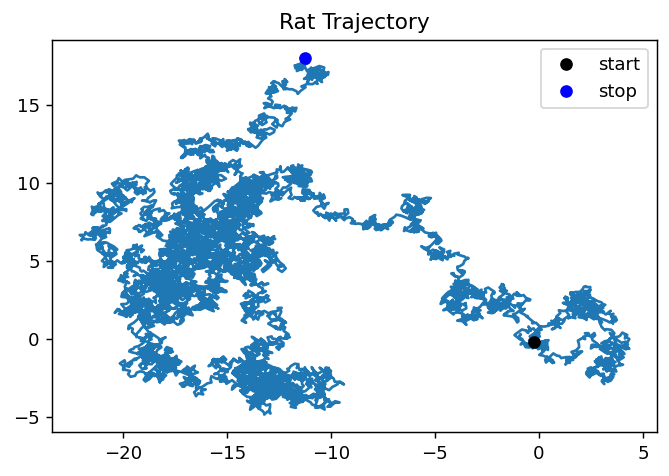

In [14]:
#@title Simulated Velocity Inputs:

def simulate_random_velocity(duration, dt, step_size):
    """
    Inputs
    
    """
    x = step_size * cumsum((random(int(duration/dt)) - 0.5))
    y = step_size * cumsum((random(int(duration/dt)) - 0.5))

    # velocity = column_stack((x, y))

    return x / second, y / second

step_size = 0.5*metre
dt = 0.1*ms
velocity_array_x, velocity_array_y = simulate_random_velocity(duration, dt, step_size)


figure(dpi=130)
plot(velocity_array_x[:], velocity_array_y[:])
plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
title("Rat Trajectory")
legend()



### Random trajectory:
(Based on Mittal and Narayanan, 2020)
1. Starting step of the animal (x_0, y_0) = (0, 0)
2. At each timestep (=0.1ms) two random numbers are picked, $d_t \in [0, 0.004*dt]$ & $A_t \in [-\pi/36, \pi/36]$
$$ x_t = x_{t-1} + d_tsin(A_t) $$
$$ y_t = y_{t-1} + d_tcos(A_t) $$
3. To enable sharp turns neart the boundaries of the arena, the A_t random variable was picked from a uniform distribution of $A_t \in [0, 2\pi]$ instead of uniform distribution of $ A_t \in [-\pi/36, \pi/36] $ if either $x_{t-1}$ or $y_{t-1}$ is too close to the boundaries. 

In [16]:
def within_boundary(x, y, n):
    if x < n and y < n and y > 0 and x > 0:
        return True
    else:
        return False

def close_to_boundary(x, y, n, epsilon):
    if abs(x - n) < epsilon:
        return True
    elif abs(y -n) < epsilon:
        return True
    elif abs(x - 0) < epsilon:
        return True
    elif  abs(y - 0) < epsilon:
        return True
    else:
        return False

def get_trajectory(n, step_size, dt, duration, epsilon=0.05):
    """
    n - size of neural sheet (also size of field for animal)
    step_size - each step is drawn from a uniform distribution over [0, step_size]
    dt - timestep size (in ms)
    duration - total simulation size (in ms)
    """

    nb_steps = int(duration/dt)
    angle = zeros(nb_steps)
    x = empty(nb_steps + 1)
    y = empty(nb_steps + 1)
    x[0] = y[0] = n/2

    for i in range(1, nb_steps+1):


        if close_to_boundary(x[i-1], y[i-1],n, epsilon):
            new_angle = np.random.uniform(0, 2*pi)
        else:
            new_angle = np.random.uniform(-pi/36, pi/36)

        step = np.random.uniform(0, step_size)
        x[i] = x[i-1] + step*sin(angle[i-1] + new_angle)
        y[i] = y[i-1] + step*cos(angle[i-1] + new_angle)
        
        while not(within_boundary(x[i], y[i], n)):
            new_angle = np.random.uniform(-pi/36, pi/36)
            step = np.random.uniform(0, step_size)
            x[i] = x[i-1] + step*sin(angle[i-1] + new_angle)
            y[i] = y[i-1] + step*cos(angle[i-1] + new_angle)
        
        angle += new_angle
            
    velocity_array = column_stack((diff(x)/dt, diff(y)/dt))
    position_array = column_stack((x, y))
    return position_array, velocity_array, angle

In [17]:
trajectory, velocity, angle = get_trajectory(100, 0.4, 0.1, 1000)

Text(0.5, 1.0, 'Velocity Norm')

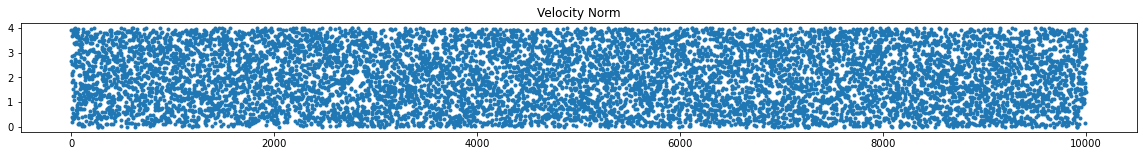

In [18]:
figure(figsize=(20, 2))
plot(np.linalg.norm(velocity, axis=1), '.')
title("Velocity Norm")

In [19]:
print("avg velocity (in m/sec) =", mean(np.linalg.norm(velocity, axis=1)))

avg velocity (in m/sec) = 1.9854550400046407


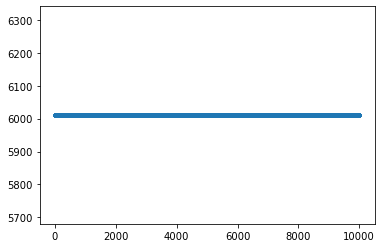

In [20]:
plot(angle*180/pi, '.')

WARNING    /tmp/ipykernel_6618/1769008943.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(trajectory[0,0], trajectory[0, 1], 'ro', label='start', color ='blue')
 [py.warnings]
WARNING    /tmp/ipykernel_6618/1769008943.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='stop', color='black')
 [py.warnings]


Text(0.5, 1.0, 'Rat Trajectory')

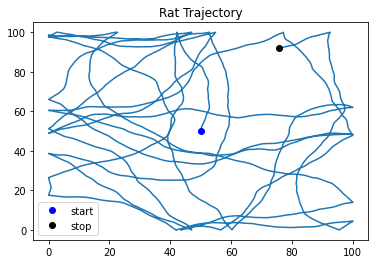

In [21]:
plot(trajectory[:, 0], trajectory[:, 1])
plot(trajectory[0,0], trajectory[0, 1], 'ro', label='start', color ='blue')
plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label='stop', color='black')
legend()
title("Rat Trajectory")

In [16]:
def zero_velocity(dt, duration):
    nb_steps = int(duration/dt)
    x = zeros(nb_steps)
    y = zeros(nb_steps)
    velocity = column_stack((x, y))
    return velocity

velocity = zero_velocity(defaultclock.dt, duration)

In [17]:
dt = defaultclock.dt
V_x = TimedArray(velocity[:, 0]*metre/second, dt=dt)
V_y = TimedArray(velocity[:, 1]*metre/second, dt=dt)

In [18]:
print(V_x(1*second))

0. m/s


### Straight Trajectory



In [13]:
def straight_trajectory(dt, duration, speed):
    """
    
    Args:
        dt - 
        duration - 
        speed - in metres/sec
    """
    
    nb_steps = int(duration/dt)
    angle = np.random.random()*pi/4
    
    x = cos(angle)*arange(0, nb_steps+1)*speed*dt
    y = sin(angle)*arange(0, nb_steps+1)*speed*dt

    velocity_x = diff(x)/dt
    velocity_y = diff(y)/dt

    velocity = column_stack((velocity_x, velocity_y))
    trajectory = column_stack((x, y))


    return trajectory, velocity


In [ ]:
dt = defaultclock.dt
trajectory, velocity = straight_trajectory(dt, duration, 100)
V_x = TimedArray(velocity[:, 0]*metre/second, dt=dt)
V_y = TimedArray(velocity[:, 1]*metre/second, dt=dt)

In [19]:
print("Running the simulation")
run(duration)

Running the simulation


In [19]:
print("Running the simulation")
net = Network(collect()) # Automatically include explicitly defined groups like neural populations and monitors
net.add(S) # manually add the "hidden" synapses
net.run(duration)

Running the simulation


In [20]:
M_s.num_spikes

2122

In [21]:
M_i.i[M_i.t[:] == 0]

array([], dtype=int32)

In [22]:
plot(trajectory[:, 0], trajectory[:, 1])

NameError: name 'trajectory' is not defined

### Plot Connectivity

S:
* 0 - 4 : north > north, south, east, west, inh
* 5 - 9 : south > north, south, east, west, inh
* 10 - 14: east > north, south, east, west, inh


In [23]:
def plot_random(num_traces, N, traces):
    a = np.random.randint(0, N, num_traces)
    a = np.sort(a)
    for i in a:
        plot(traces[i, :], label="Neuron " + str(i))
    legend()

Text(0.5, 1.0, 'Membrane Potential in Inh. Pop')

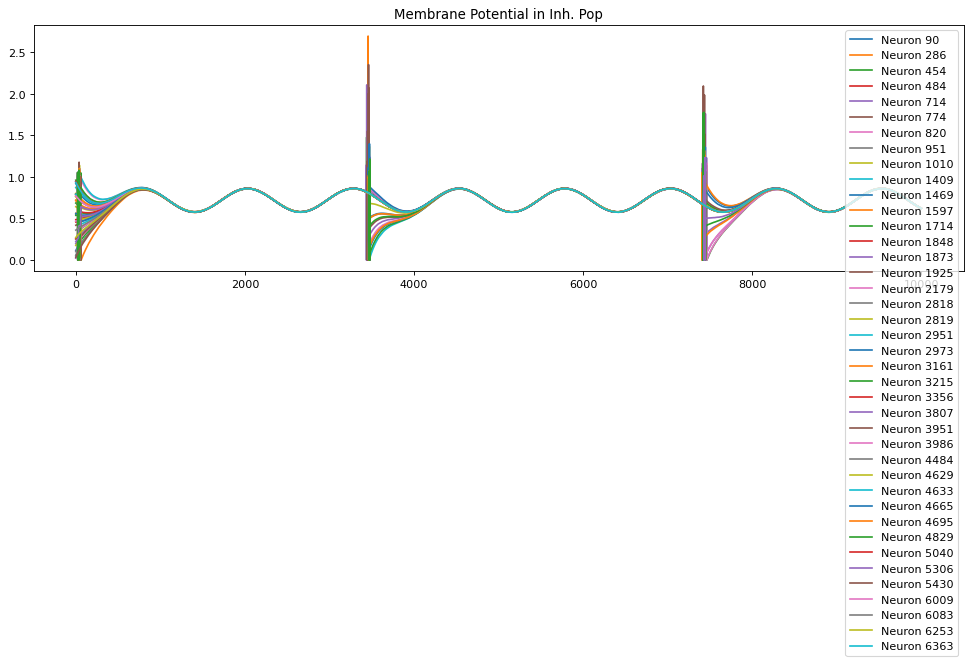

In [27]:
num_traces = 40
style.use('default')
figure(figsize=(15, 4), dpi=80)
plot_random(num_traces, N, State_i.v)
title("Membrane Potential in Inh. Pop")

Text(0.5, 1.0, 'Membrane Potential in Exc_n Pop')

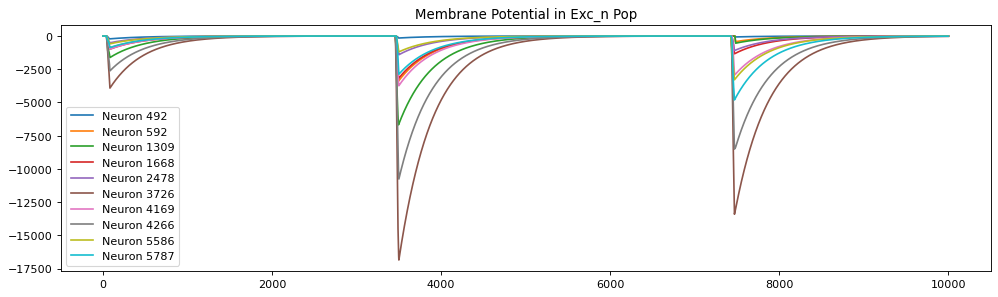

In [25]:
num_traces = 10
# style.use('bmh')
figure(figsize=(15, 4), dpi=80)
plot_random(num_traces, N, State_n.v)
title("Membrane Potential in Exc_n Pop")

Text(0.5, 1.0, 'Membrane Potential in Exc_e Pop')

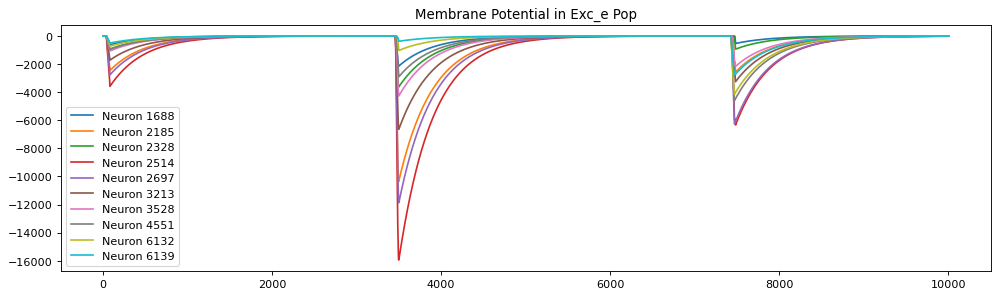

In [26]:
num_traces = 10
# style.use('bmh')
figure(figsize=(15, 4), dpi=80)
plot_random(num_traces, N, State_e.v)
title("Membrane Potential in Exc_e Pop")

### Plotting Functions

#### Spike Rasters

Text(0.5, 1.0, 'P_n Raster Plot')

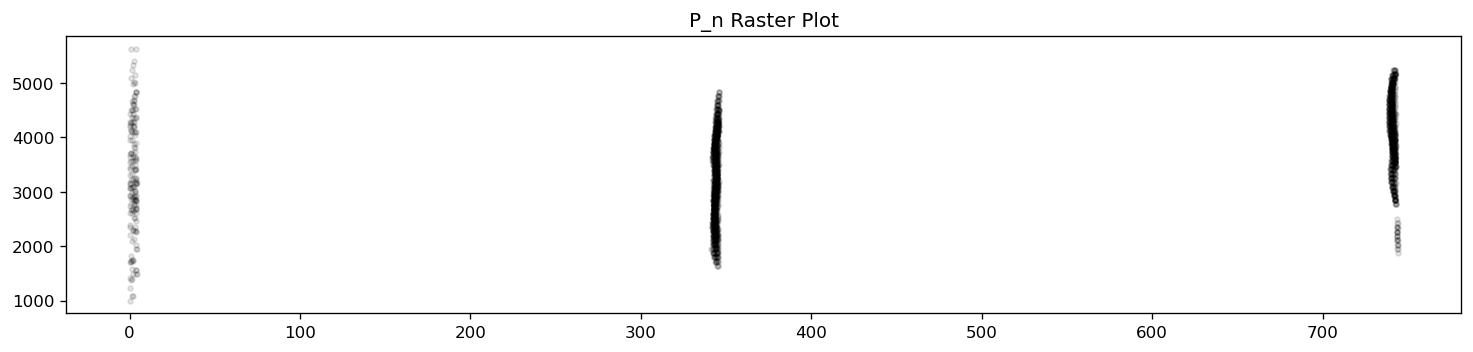

In [28]:
figure(dpi=120, figsize=(15,3))
plot(M_n.t/ms, M_n.i, '.k', alpha=0.1)
title("P_n Raster Plot")

Text(0.5, 1.0, 'P_s Raster Plot')

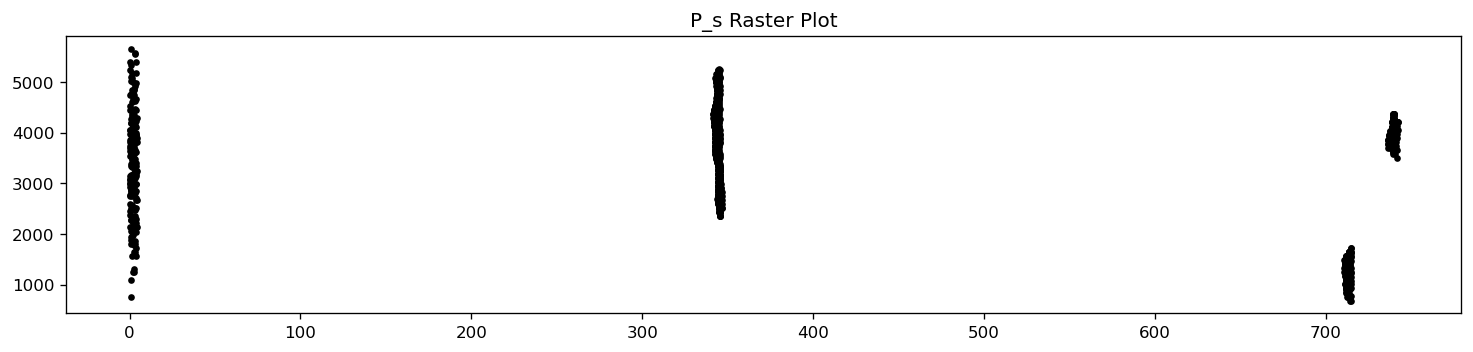

In [36]:
figure(dpi=120, figsize=(15,3))
plot(M_s.t/ms, M_s.i, '.k')
title("P_s Raster Plot")

Text(0.5, 1.0, 'P_e Raster Plot')

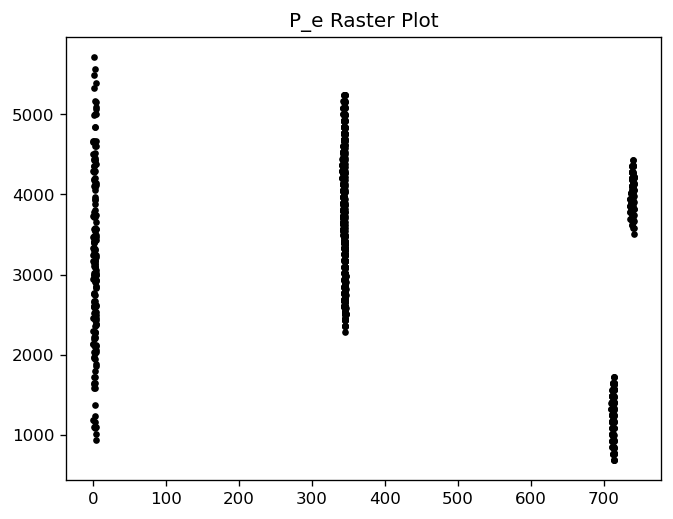

In [28]:
figure(dpi=120)
plot(M_e.t/ms, M_e.i, '.k')
title("P_e Raster Plot")

Text(0.5, 1.0, 'P_w Raster Plot')

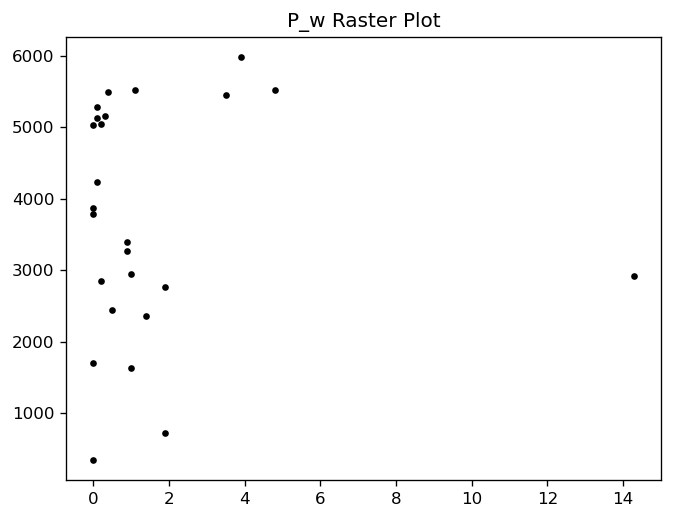

In [30]:
figure(dpi=120)
plot(M_w.t/ms, M_w.i, '.k')
title("P_w Raster Plot")

Text(0.5, 1.0, 'P_i Raster Plot')

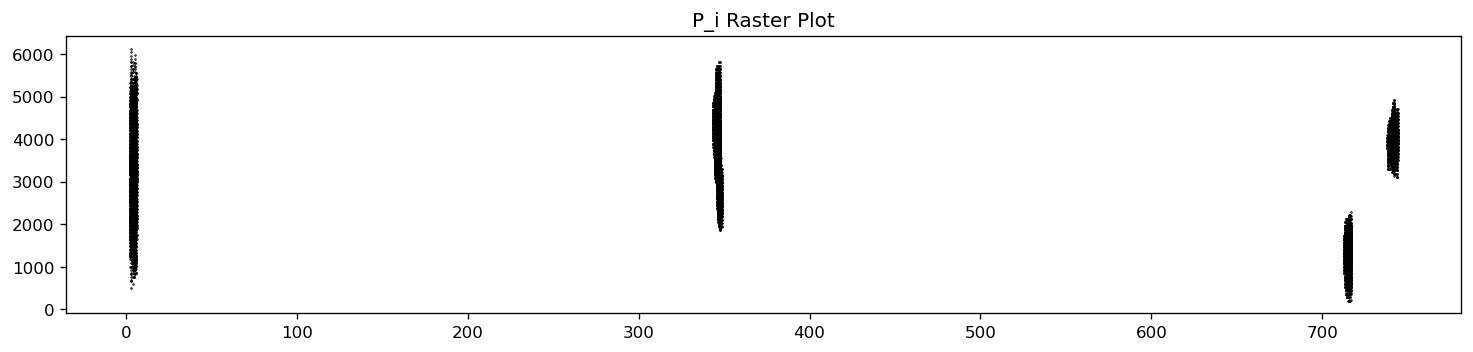

In [38]:
figure(dpi=120, figsize=(15,3))
plot(M_i.t/ms, M_i.i, '.k', markersize=0.9)
title("P_i Raster Plot")

#### Neural Dynamics Plots

1. Plot membrane potential heatmap animation:

        Membrane potential image plot as a time-series animation
2. Plot spikemap animation:

        Spike on a x-y plot corresponding to their location

In [28]:
int(duration/defaultclock.dt)

10000

In [26]:
t = 0
# Create 2-D Matrix consisting of membrane potential
Potential_n = empty((n, n, int(duration/defaultclock.dt)))
print("Creating potential heatmap array")
for i in tqdm(range(N)):
    x = int(i % n)
    y = i // n
    Potential_n[x, y, :] = State_n.v[i]


Creating potential heatmap array


100%|██████████| 1600/1600 [01:01<00:00, 26.07it/s]


Plotting potential heatmap


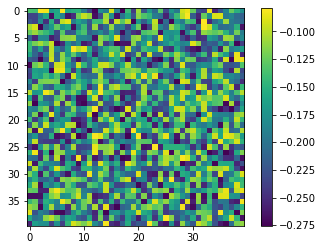

In [27]:
# print("Plotting potential heatmap")
# imshow(Potential_n[:, :, 650])
# colorbar()

In [27]:
# fig = plt.figure()
# ax = plt.axes()

# def ani_potential_heatmap(i):
#     """
#     Draws each frame of the animation
#     """
#     time_bin = i # the theta cycle to plot activity
#     module_no = 1
    
#     fig.clear()
#     imshow(Potential_n[:, :, time_bin])
#     draw()

# anim = FuncAnimation(fig, ani_potential_heatmap, frames=100, interval=500)

# writervideo = animation.FFMpegWriter()
# anim.save('increasingStraightLine.mp4', writer=writervideo)


#### 

#### Plot Connectivity

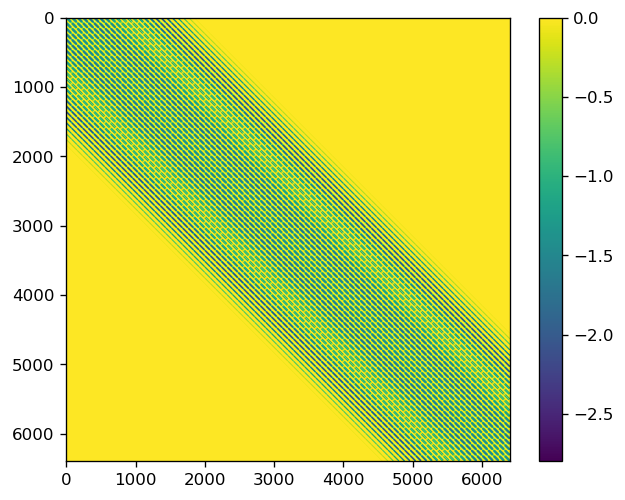

In [29]:
synapse_ind = 22
connectivity = zeros((N, N))
connectivity[S[synapse_ind].i[:], S[synapse_ind].j[:]] = S[synapse_ind].w[:]
figure(dpi=120)
imshow(connectivity)
colorbar()

This is great! Each neuron is connected only to a few neurons around it, as it should be

##### Plot Connectivity for a single neuron

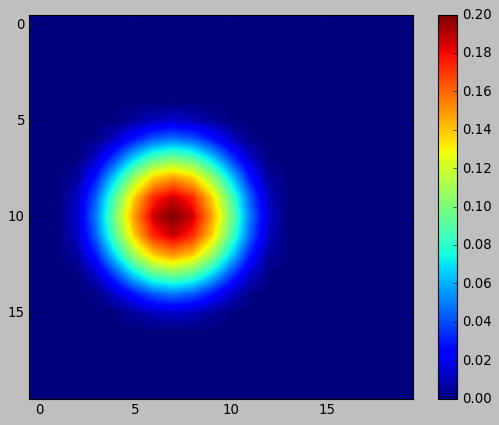

In [25]:
n_id = 3240
syn_id = 10
# style.use('classic')
connection_matrix = zeros((N, N))
connection_matrix[S[syn_id].i[:], S[syn_id].j[:]] = S[syn_id].w[:]
connection_matrix = connection_matrix[n_id].reshape((n, n))
imshow(connection_matrix[30:50, 30:50])
colorbar()

### Plot inhibitory connectivity:

In [ ]:
n_id = 3240
syn_id = 20 # inhibitory synapses from inhibitory population to north population
# style.use('classic')
connection_matrix = zeros((N, N))
connection_matrix[S[syn_id].i[:], S[syn_id].j[:]] = S[syn_id].w[:]
connection_matrix = connection_matrix[n_id].reshape((n, n))
imshow(connection_matrix[30:50, 30:50])
colorbar()

### Plot spikes on location:
Plot spikes from any single neuron as points at the corresponding location of the animal, over the entire simulation

In [30]:
def plot_spike_location(spike_times, trajectory):
    """
    x - x-coordinate of neuron
    y - y-coordinate of neuron
    n - side-length of neural sheet
    spike_times - array containing the spike times of the neuron
    trajectory - position array of animal
    """
    
    spike_location = empty((len(spike_times), 2))
    for t in range(len(spike_times)):
        spike_location[t] = trajectory[t]
    
    plot(spike_location[:,0], spike_location[:, 1], '.')
    xlabel("x (in m)")
    ylabel("y (in m)")
    title("Spike Locations")

[0.3738 0.6186] s
[0.3738 0.6186]


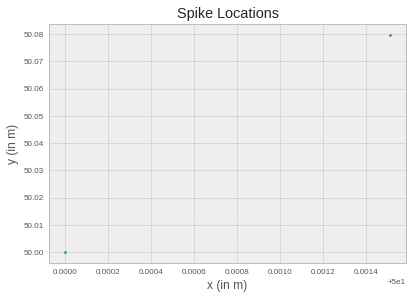

In [91]:
    # x, y = 10, 12
    # i = y*n + x # neuron id
    i = 429
    spike_times_i = M_n.t[M_n.i == i]
    print(spike_times_i[:])
    print(spike_times_i/second)
    plot_spike_location(spike_times_i, trajectory)
    

In [31]:
def pop_spike_plot(timestep, dt, time_window, spike_mon):
    """
    Plot spikes at the respective neural location for each timestep
    """
    t = timestep*dt
    # spike_ids = spike_mon.i[spike_mon.t[:] <= t + time_window and spike_mon.t[:] >= t - time_window]
    
    spike_ids = spike_mon.i[spike_mon.t[:] == t]

    x = spike_ids % n
    y = spike_ids // n
    plot(x, y, '.')

    return None 

    

In [ ]:
for i in range(500):
    pop_spike_plot(i, dt, 5 * second, M_n)
    show()

### Plot excitatory synaptic drive:


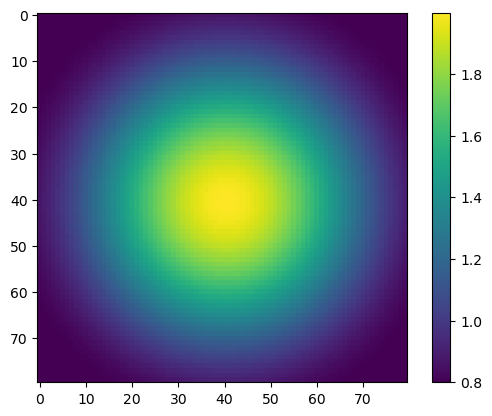

In [31]:
a_plus_image = P_n.a_plus[:].reshape(n, n)
imshow(a_plus_image)
colorbar()

In [32]:
type(P_n.rho_[:])

numpy.ndarray

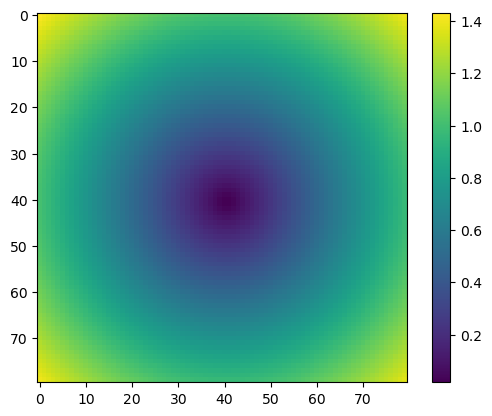

In [33]:
rho_image = P_n.rho_[:].reshape(n, n)
imshow(rho_image)
colorbar()

### Simulation Protocol:
Kang & DeWeese, 2019:
1. Initialize each neuron to a random membrane potential between 0 and 1.
2. Evolve acc to equation 2 & 3 for 500 timesteps without velocity inputs to generate a rough grid like pattern
3. 3 evolutions of timesteps with constant velocity of 0.5 m/sec and angles pi/2 - pi/5, 2pi/5 and pi/4 successively to make the grid more regular and anneal grid defects.
4. Evolve the network for 4 laps without idle periods.

Learning allocentric inputs:

5. 2 additional laps of idle periods at each end of this task.
    During that time, both excitatory and inhibitory drives are maintained at their run values without theta oscillations.

### Recording from a subset:


#### Prototyping rho_value and a_plus

In [52]:
def rho_value_test(x, y, N):

    value = sqrt(((x - ((N+1)/2))**2 + (y - ((N+1)/2))**2)/(N/2))

    return value

In [58]:
i = arange(0, n*n)
x = i % n
y = i // n

rho = rho_value_test(x, y, n)


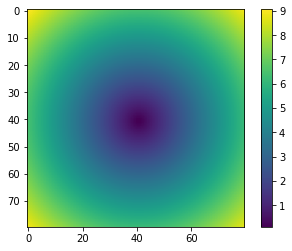

In [60]:
imshow(rho.reshape(80, 80))
colorbar()

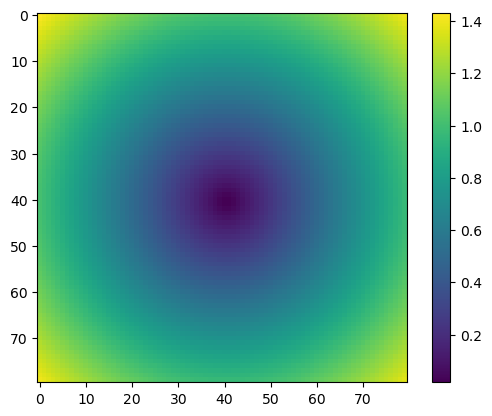

In [31]:
def rho_value_test_2(x, y, n):

    value = sqrt(((x - ((n+1)/2))**2 + (y - ((n+1)/2))**2))/(n/2)

    return value

i = arange(0, n*n)
x = i % n
y = i // n

rho = rho_value_test_2(x, y, n)
imshow(rho.reshape(80, 80))
colorbar()